In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rfpimp

import utils
from data_statistical_features import Segment, SegmentStatistical
import eda_utils

import os

plt.rcParams.update(utils.get_plt_settings())

save=True

/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data

In [2]:
df = pd.read_csv(utils.get_own_features_csv_path(segment_length=10, overlap_amount=0.9, hr_threshold=10, data_folder='data_patients'), index_col=False)
features = df.drop(Segment.get_feature_name_array(), axis='columns')
informative_inf = df[Segment.get_feature_name_array()]
features_new = df.drop(SegmentStatistical.get_feature_name_array(), axis='columns')

df.columns = [col.replace("_", " ") for col in df.columns]
features.columns = [col.replace("_", " ") for col in features.columns]
informative_inf.columns = [col.replace("_", " ") for col in informative_inf.columns]
features_new.columns = [col.replace("_", " ") for col in features_new.columns]

target = df['informative']
patient_id = df['patient id']

df_new = features_new.copy()
df_new['error'] = df['error']
df_new['informative'] = df['informative']

from ml_statistical_features import get_patient_split
x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.33)
x_train = x_train.dropna()
x_test = x_test.dropna()
y_train = y_train.loc[x_train.index]
y_test = y_test.loc[x_test.index]

# Correlation Heatmap

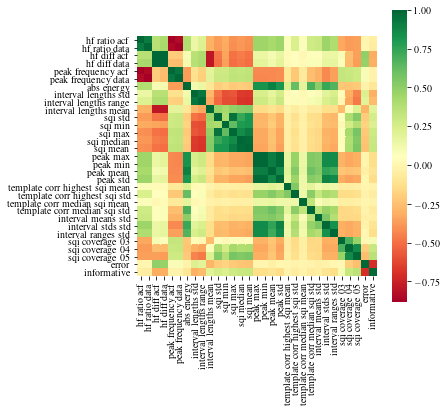

In [3]:
width, _ = utils.get_plt_normal_size()
plt.figure(figsize=(width*1.3, width*1.3))

sns.heatmap(df_new.loc[x_train.index].corr(), square=True, cmap ="RdYlGn", xticklabels=True, yticklabels=True)

In [4]:
corr_colls = eda_utils.get_correlated_columns(features, 0.95)
corr_colls

['maximum',
 'std',
 'range',
 'mad',
 'variance local minima',
 'mean signal envelope',
 'hf diff data',
 'abs energy',
 'sqi max',
 'sqi mean',
 'peak max',
 'peak min',
 'peak mean',
 'peak std']

In [5]:
fdm = rfpimp.feature_dependence_matrix(x_train)

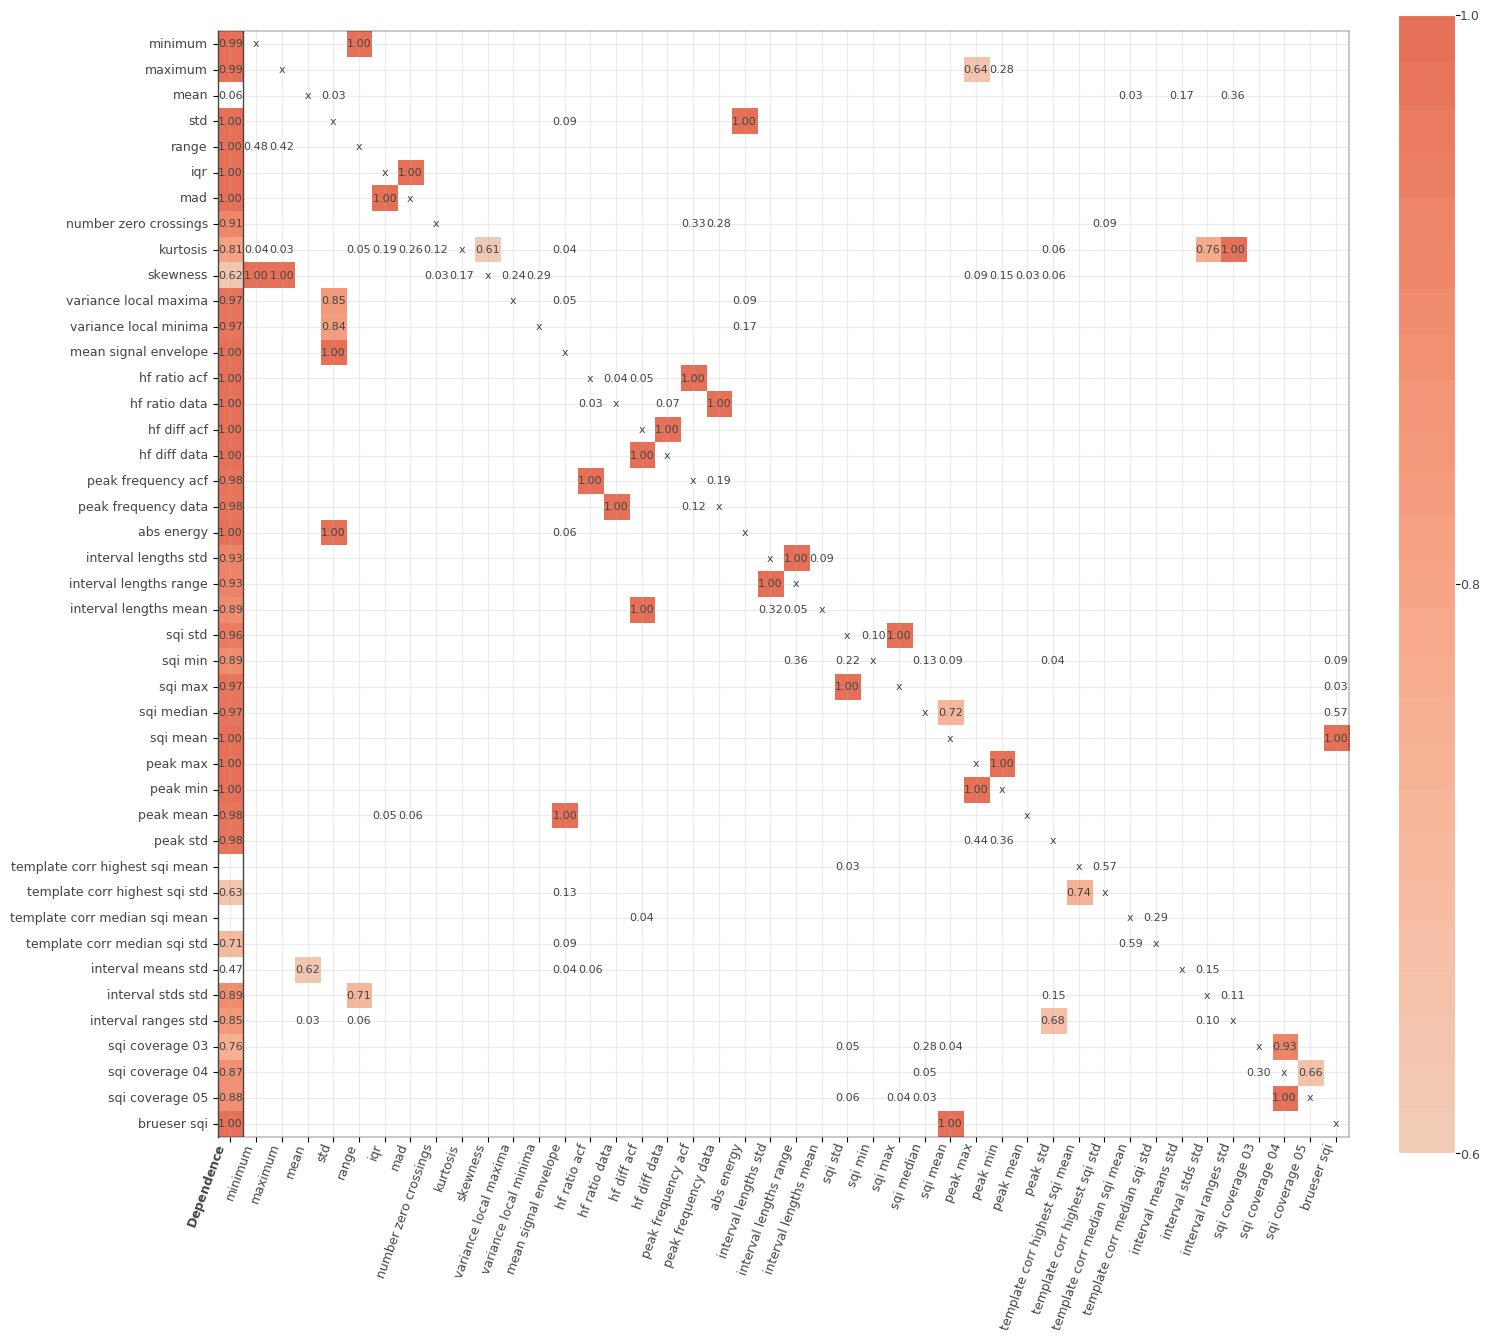

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
rfpimp.plot_dependence_heatmap(fdm, figsize=(15, 15), value_fontsize=8, label_fontsize=9)
plt.rcParams.update(utils.get_plt_settings())

In [12]:
fdm_new = rfpimp.feature_dependence_matrix(x_train[features_new.columns])

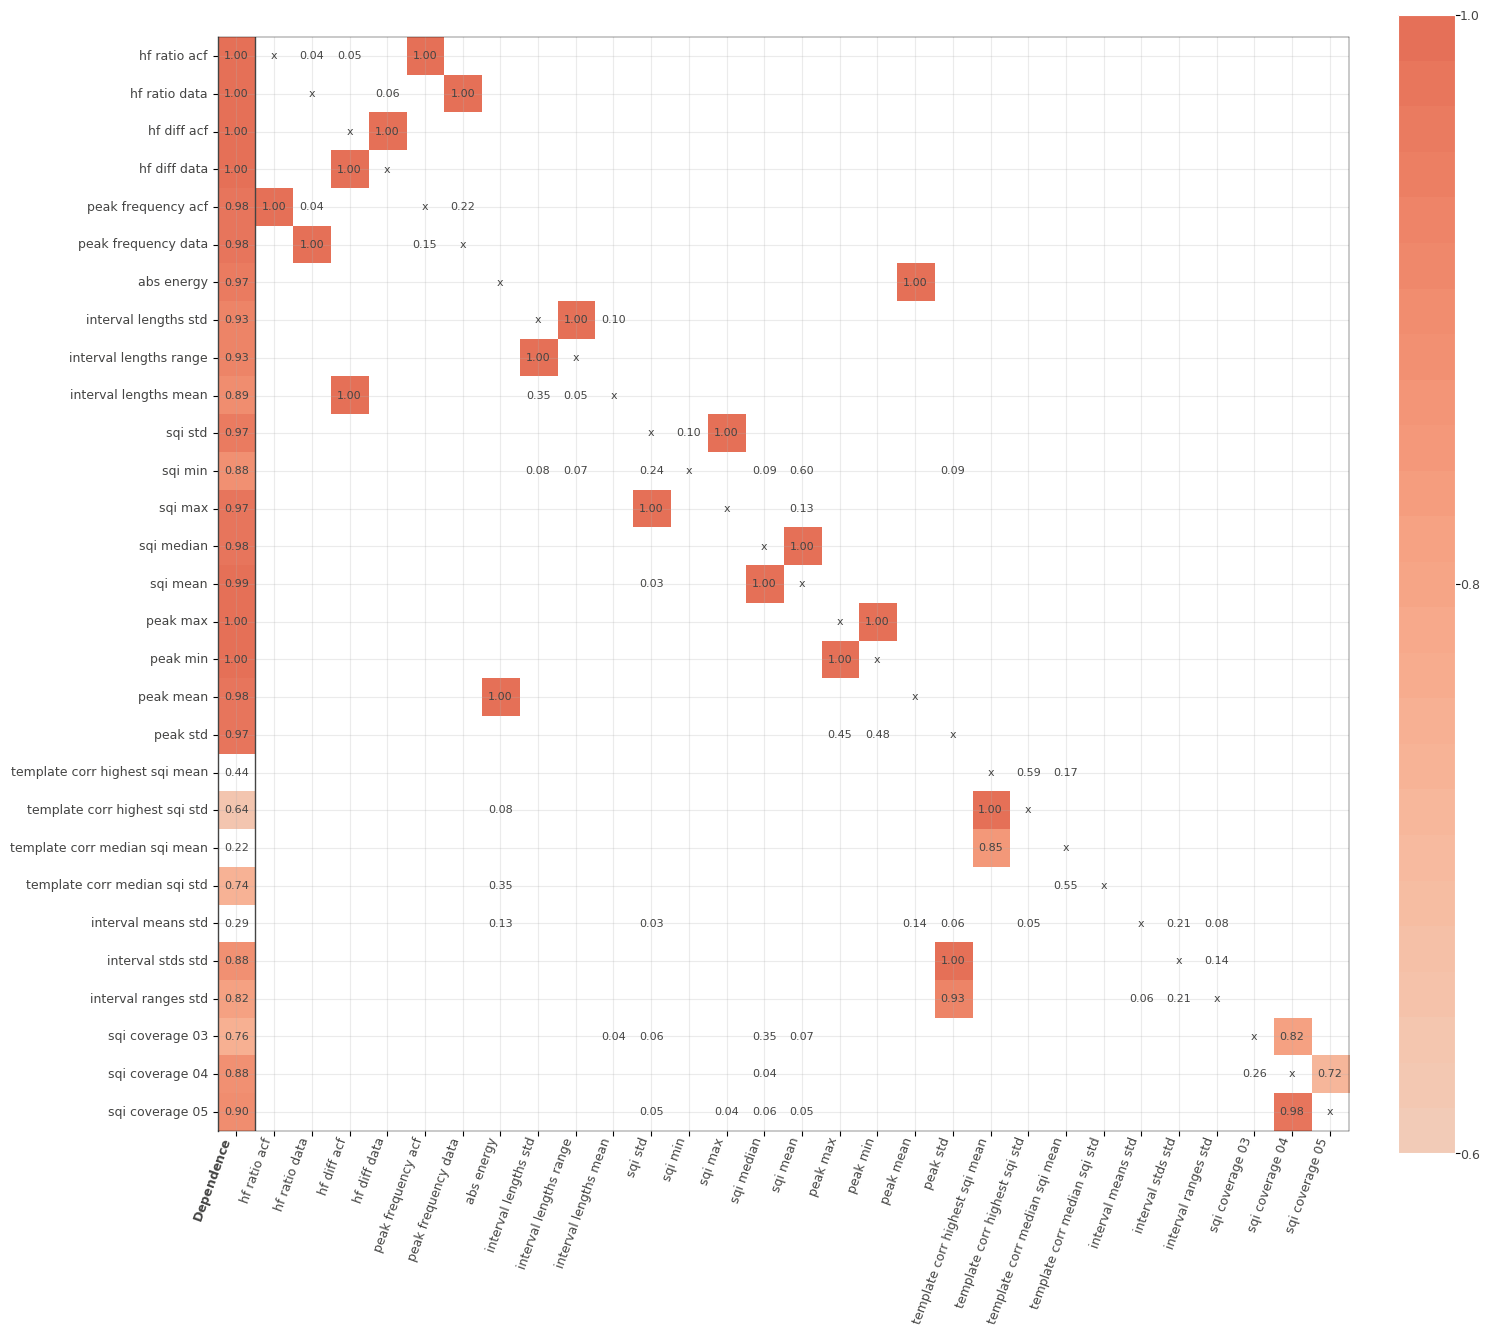

In [13]:
plt.rcParams.update(plt.rcParamsDefault)
rfpimp.plot_dependence_heatmap(fdm_new, figsize=(15, 15), value_fontsize=8, label_fontsize=9)
plt.rcParams.update(utils.get_plt_settings())

In [12]:
fdm_reduced = rfpimp.feature_dependence_matrix(x_train.drop(['maximum', 'minimum', 'mean signal envelope', 'mad',
                                                             'variance local minima', 'variance local maxima','iqr',
                                                             'range', 'peak frequency data', 'peak frequency acf', 'peak max',
                                                             'abs energy'
                                                            ],
                                                            axis='columns'))

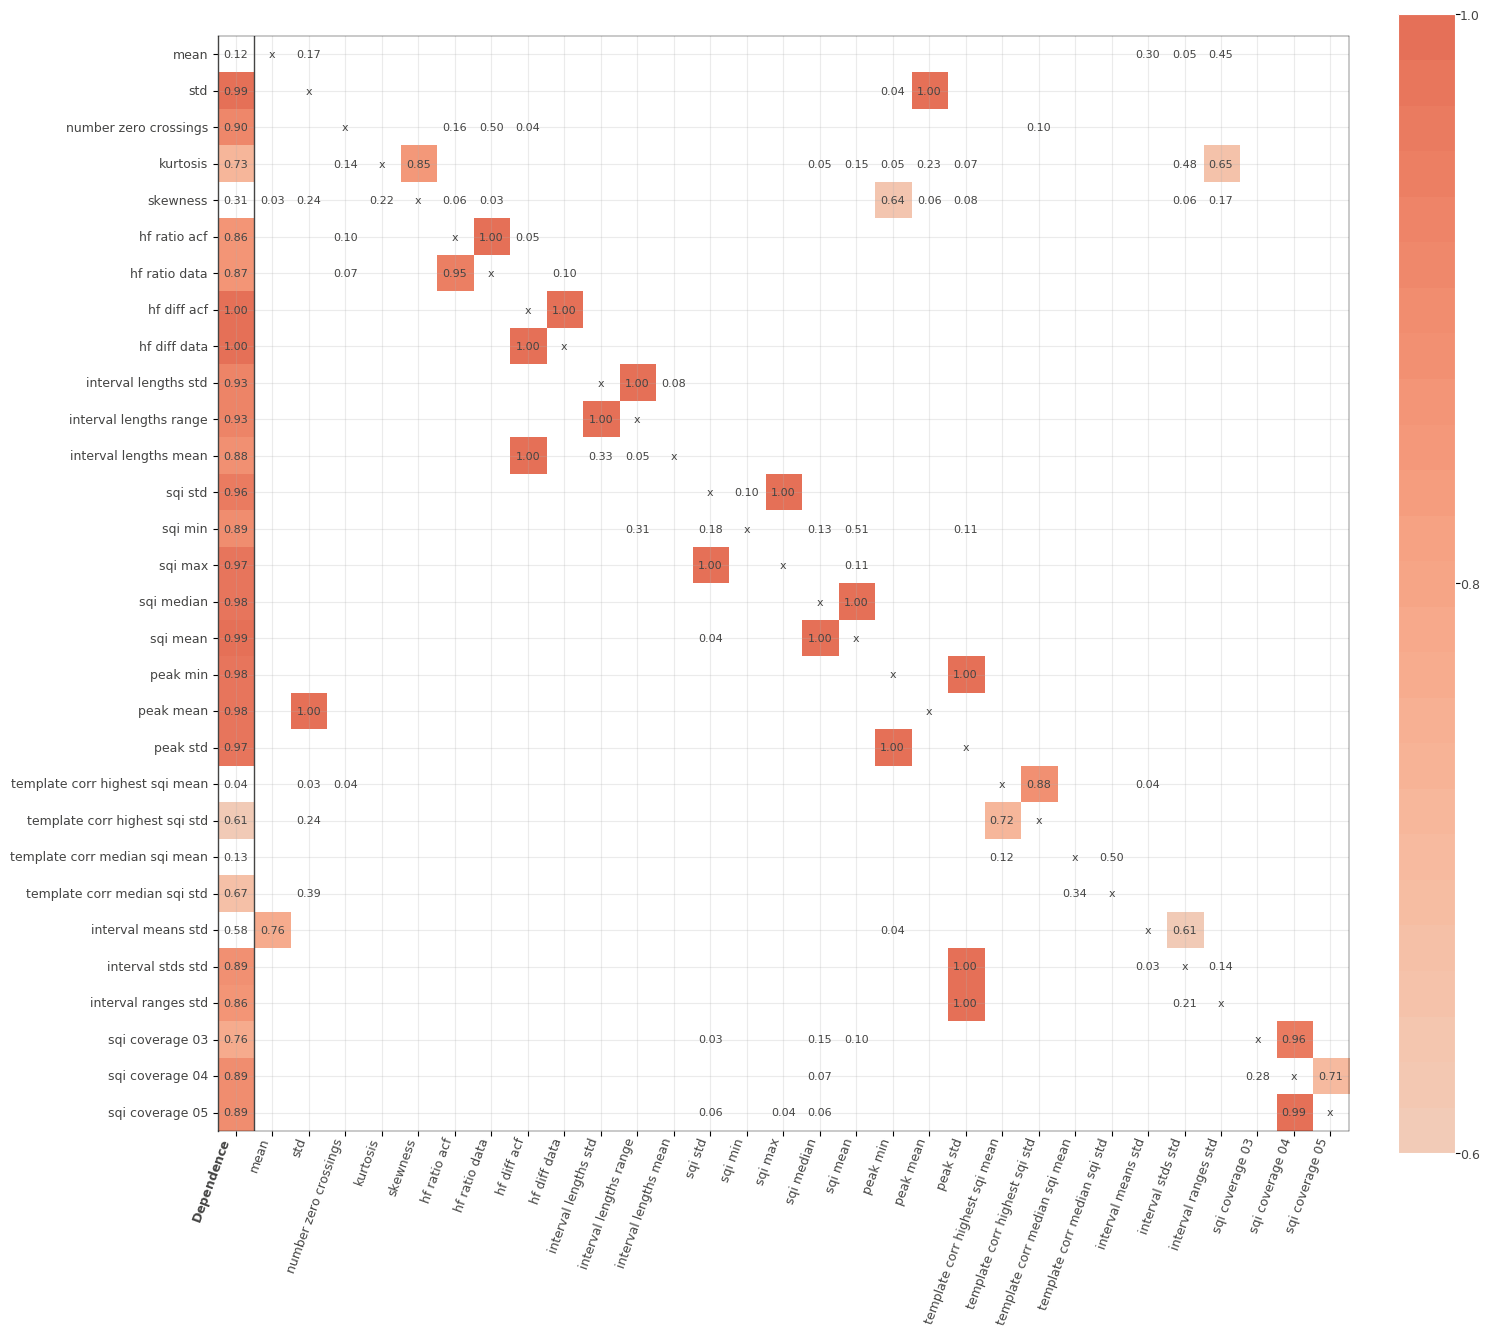

In [13]:
plt.rcParams.update(plt.rcParamsDefault)
rfpimp.plot_dependence_heatmap(fdm_reduced, figsize=(15, 15), value_fontsize=8, label_fontsize=9)
plt.rcParams.update(utils.get_plt_settings())

In [14]:
x_train.drop(['maximum', 'minimum', 'mean signal envelope', 'mad','variance local minima', 'variance local maxima',
              'iqr', 'range', 'peak frequency data', 'peak frequency acf', 'peak max', 'abs energy'
             ], axis='columns').columns

Index(['mean', 'std', 'number zero crossings', 'kurtosis', 'skewness',
       'hf ratio acf', 'hf ratio data', 'hf diff acf', 'hf diff data',
       'interval lengths std', 'interval lengths range',
       'interval lengths mean', 'sqi std', 'sqi min', 'sqi max', 'sqi median',
       'sqi mean', 'peak min', 'peak mean', 'peak std',
       'template corr highest sqi mean', 'template corr highest sqi std',
       'template corr median sqi mean', 'template corr median sqi std',
       'interval means std', 'interval stds std', 'interval ranges std',
       'sqi coverage 03', 'sqi coverage 04', 'sqi coverage 05'],
      dtype='object')

# Paarweise geplottet

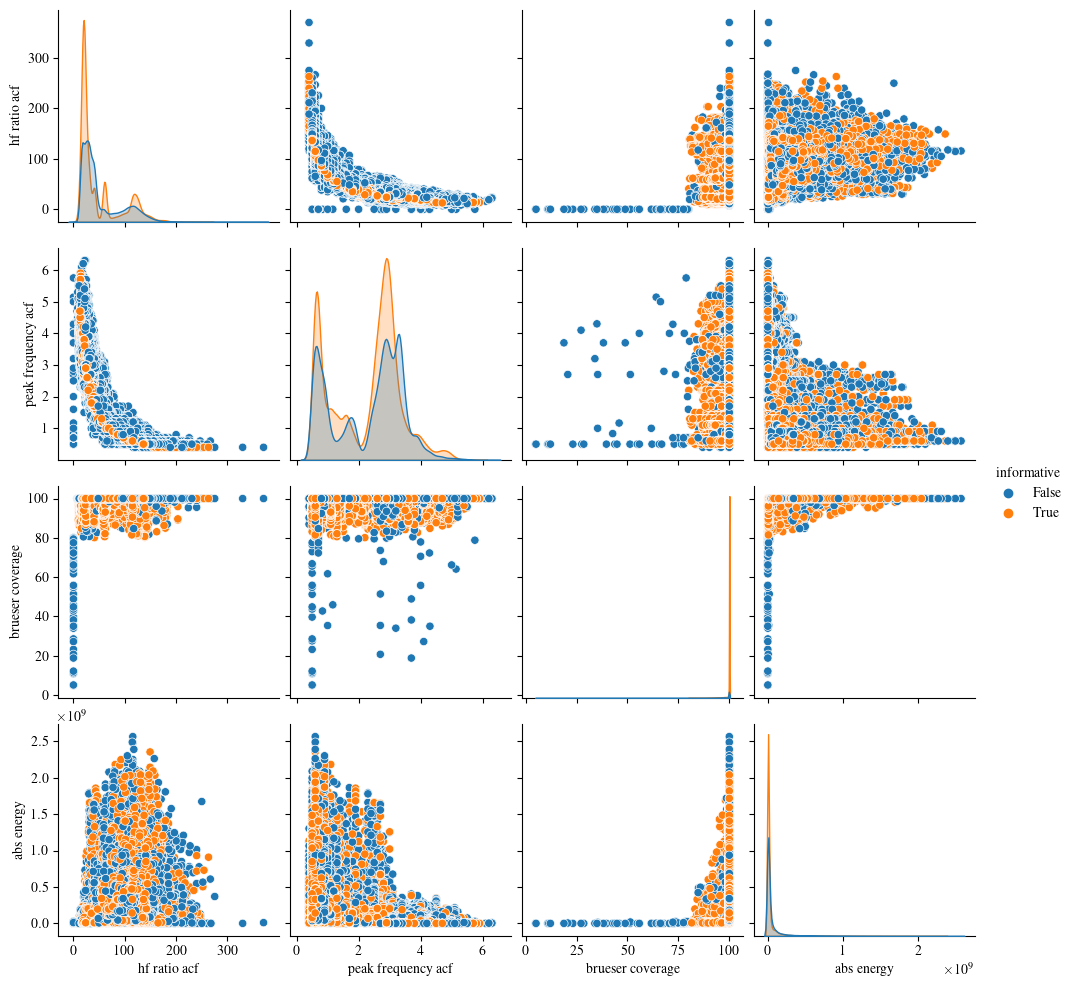

In [15]:
cols = ['hf ratio acf', 'peak frequency acf', 'brueser coverage', 'abs energy', 'informative']
sns.pairplot(df.loc[x_train.index, cols], kind='scatter', hue='informative', dropna=True)


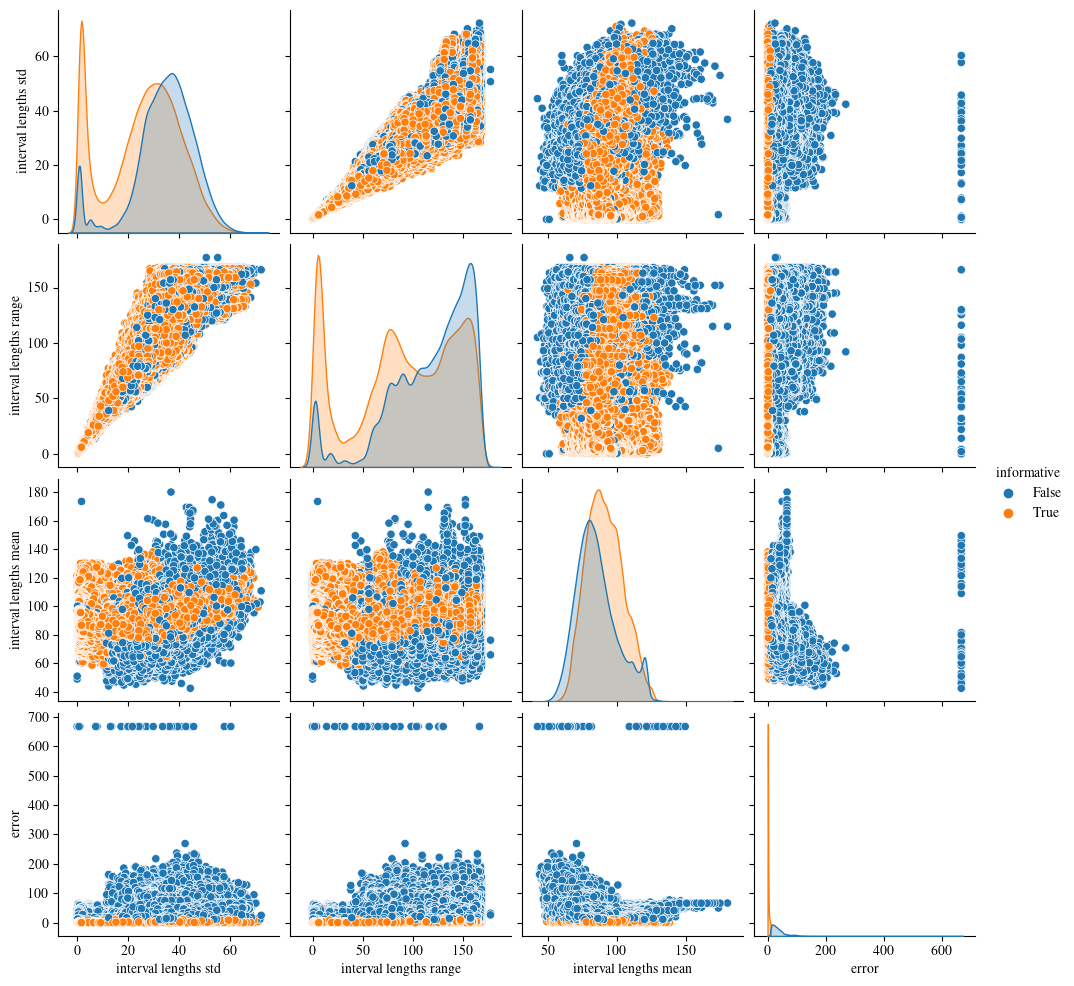

In [16]:
cols = ['interval lengths std', 'interval lengths range', 'interval lengths mean', 'error', 'informative']
sns.pairplot(df.loc[x_train.index, cols], kind='scatter', hue='informative', dropna=True)


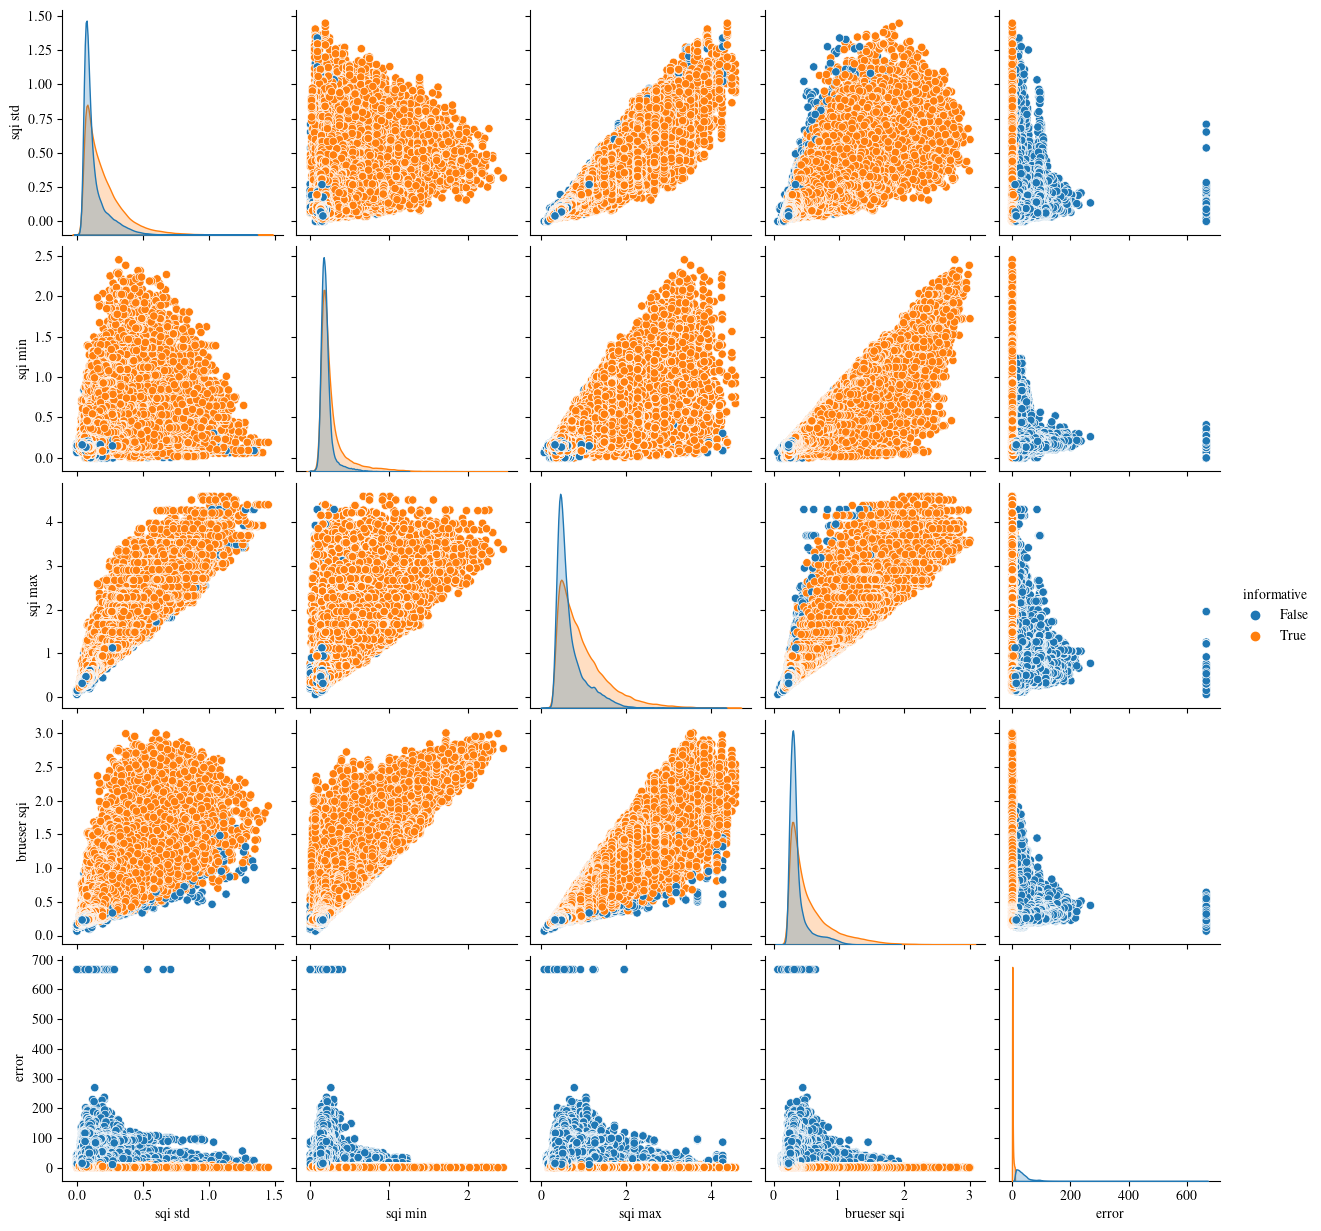

In [17]:
cols = ['sqi std', 'sqi min', 'sqi max', 'brueser sqi', 'error', 'informative']
sns.pairplot(df.loc[x_train.index, cols], kind='scatter', hue='informative', dropna=True)

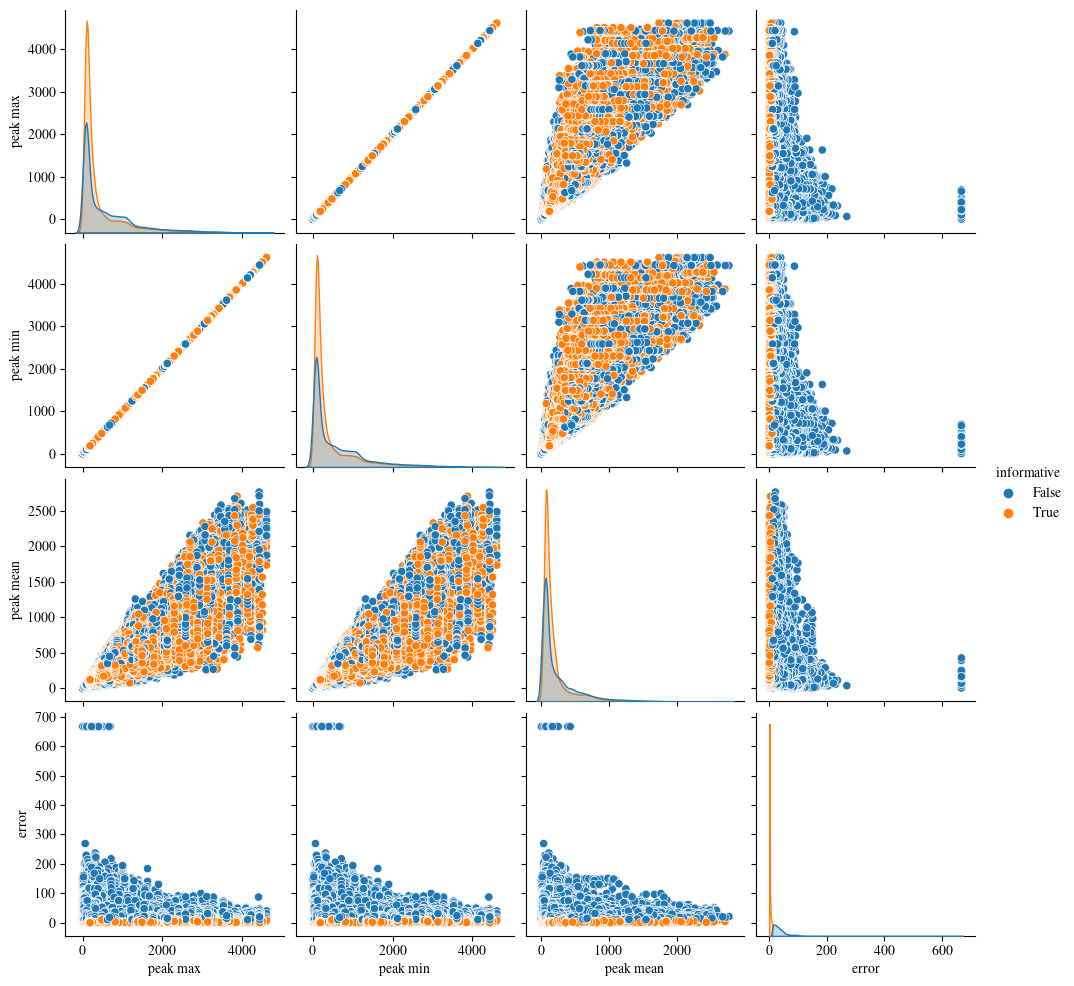

In [18]:
cols = ['peak max','peak min', 'peak mean', 'error', 'informative']
sns.pairplot(df.loc[x_train.index, cols], kind='scatter', hue='informative', dropna=True)

# Einfluss der Merkmale bei Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from estimators import OwnEstimatorRegression, OwnEstimatorClassification

In [ ]:
# forest_regr = RandomForestRegressor(random_state=1, n_jobs=-2, verbose=1)
forest_regr = None

rf_regr = OwnEstimatorRegression(forest_regr, path='rf_regr_2010.sav')

In [ ]:
rf_regr.print_model_test_report()

In [ ]:
rf_regr.print_regression_test_report()

In [ ]:
importances = rf_regr.clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(rf_regr.features.columns)):
    print("%2d) %-*s %f" % (f + 1, 30, rf_regr.features.columns[indices[f]], importances[indices[f]]))
plt.figure(figsize=utils.get_plt_big_size())
plt.bar(range(len(rf_regr.features.columns)), importances[indices], align='center')
plt.xticks(range(len(rf_regr.features.columns)), [name.replace("_", " ") for name in rf_regr.features.columns[indices]], rotation=45, ha="right")
plt.xlim([-1, len(rf_regr.features.columns)])
plt.tight_layout()
plt.show()

In [21]:
features = ['mean', 'std', 'number_zero_crossings', 'kurtosis', 'skewness',
            'hf_ratio_acf', 'hf_ratio_data', 'hf_diff_acf', 'hf_diff_data',
           'interval_lengths_std', 'interval_lengths_range',
           'interval_lengths_mean', 'sqi_std', 'sqi_min', 'sqi_max', 'sqi_median',
           'sqi_mean', 'peak_min', 'peak_mean', 'peak_std',
           'template_corr_highest_sqi_mean', 'template_corr_highest_sqi_std',
           'template_corr_median_sqi_mean', 'template_corr_median_sqi_std',
           'interval_means_std', 'interval_stds_std', 'interval_ranges_std',
           'sqi_coverage_03', 'sqi_coverage_04', 'sqi_coverage_05']
forest_regr_reduced = RandomForestRegressor(random_state=1, n_jobs=-2, verbose=1)
rf_regr_reduced = OwnEstimatorRegression(forest_regr_reduced, path='rf_regr_2210_reduced.sav', feature_selection=features)

Modell is trained, this may need some time


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed: 21.8min finished


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    6.1s finished



 Testset insgesamt
Fehler < 5    : 32.61 %
Fehler < 10   : 43.21 %
Fehler < 15   : 51.64 %
Fehler < 20   : 59.40 %
Fehler = 667  : 0.09578 %
                 precision    recall  f1-score   support

non-informative       0.67      0.88      0.76    144049
    informative       0.73      0.42      0.53    109654

       accuracy                           0.68    253703
      macro avg       0.70      0.65      0.65    253703
   weighted avg       0.69      0.68      0.66    253703

MAE auf als informativ klassifizierten Segmenten: 9.35
MAE auf als informativ annotierten Segmenten:  3.28
MAE insgesamt:  21.85
MSE auf als informativ klassifizierten Segmenten: 269.83
MSE auf als informativ annotierten Segmenten:  17.83
MSE insgesamt:  1406.50


Coverage klassifiziert      : 24.85 %
Coverage annotiert          : 43.22 %

 Coverage bestimmter Fehler des genutzten Signals auf Gesamtsignal
Fehler < 5 gesamt           : 32.61 %
Fehler < 5 klassifiziert    : 15.38 %
Fehler < 10 gesamt          

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    4.9s finished


Max Error: 667.00
MAE: 21.64
MSE: 1402.10
R_2 Score: -0.51


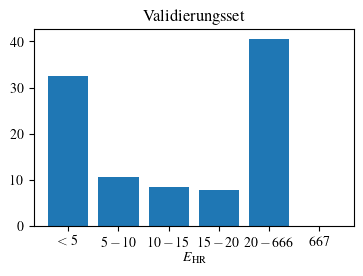

<Figure size 413.394x255.497 with 0 Axes>

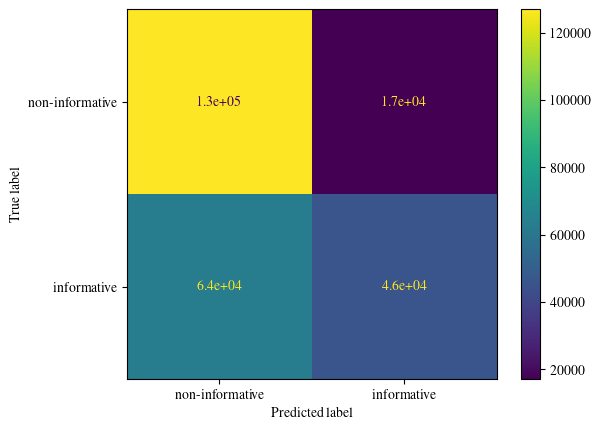

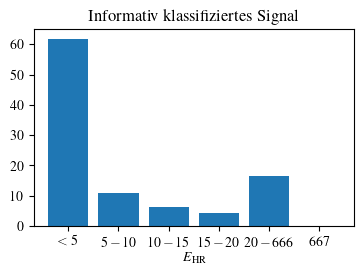

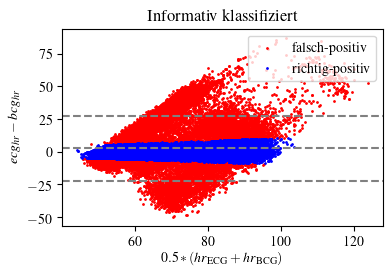

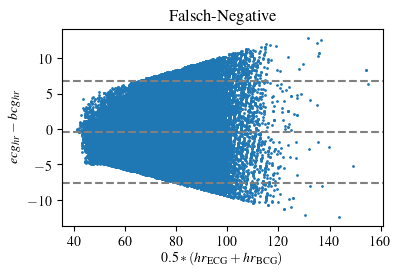

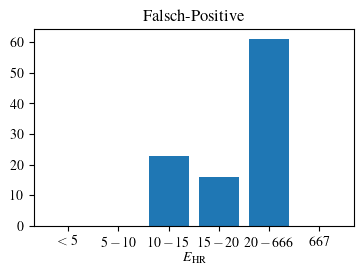

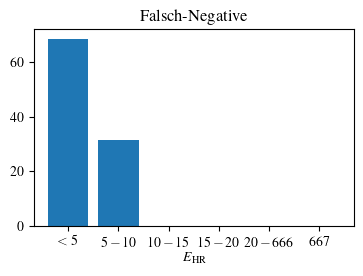

In [22]:
rf_regr_reduced.print_model_test_report()
rf_regr_reduced.print_regression_test_report()

 1) hf_diff_acf                    0.431850
 2) hf_diff_data                   0.065026
 3) number_zero_crossings          0.043206
 4) sqi_coverage_05                0.040247
 5) peak_mean                      0.036784
 6) hf_ratio_acf                   0.036226
 7) hf_ratio_data                  0.035176
 8) std                            0.026132
 9) interval_lengths_std           0.025435
10) kurtosis                       0.022137
11) interval_lengths_range         0.018990
12) sqi_std                        0.018535
13) template_corr_highest_sqi_std  0.016057
14) skewness                       0.015789
15) sqi_mean                       0.015062
16) sqi_min                        0.014477
17) interval_lengths_mean          0.014020
18) sqi_coverage_03                0.013228
19) sqi_median                     0.012104
20) peak_min                       0.011975
21) sqi_max                        0.011165
22) peak_std                       0.010477
23) template_corr_median_sqi_std

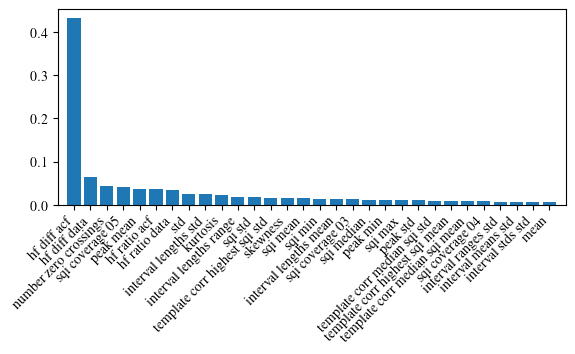

In [23]:
importances = rf_regr_reduced.clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(rf_regr_reduced.features.columns)):
    print("%2d) %-*s %f" % (f + 1, 30,rf_regr_reduced.features.columns[indices[f]], importances[indices[f]]))
plt.figure(figsize=utils.get_plt_big_size())
plt.bar(range(len(rf_regr_reduced.features.columns)), importances[indices], align='center')
plt.xticks(range(len(rf_regr_reduced.features.columns)), [name.replace("_", " ") for name in rf_regr_reduced.features.columns[indices]], rotation=45, ha="right")
plt.xlim([-1, len(rf_regr_reduced.features.columns)])
plt.tight_layout()
plt.show()

In [25]:
features = ['mean', 'std', 'number_zero_crossings', 'kurtosis', 'skewness',
            'hf_ratio_acf', 'hf_ratio_data', 'hf_diff_acf', 'hf_diff_data',
           'interval_lengths_std', 'interval_lengths_range',
           'interval_lengths_mean', 'sqi_std', 'sqi_min', 'sqi_max', 'sqi_median',
           'sqi_mean', 'peak_min', 'peak_mean', 'peak_std',
           'template_corr_highest_sqi_mean', 'template_corr_highest_sqi_std',
           'template_corr_median_sqi_mean', 'template_corr_median_sqi_std',
           'interval_means_std', 'interval_stds_std', 'interval_ranges_std',
           'sqi_coverage_03', 'sqi_coverage_04', 'sqi_coverage_05']
forest_clf_reduced = RandomForestClassifier(random_state=1, n_jobs=-2, verbose=1)
rf_clf_reduced = OwnEstimatorClassification(forest_clf_reduced, path='rf_clf_2210_reduced.sav', feature_selection=features)

Modell is trained, this may need some time


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  3.3min finished


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    6.7s finished



 Testset insgesamt
Fehler < 5    : 32.61 %
Fehler < 10   : 43.21 %
Fehler < 15   : 51.64 %
Fehler < 20   : 59.40 %
Fehler = 667  : 0.09578 %
                 precision    recall  f1-score   support

non-informative       0.74      0.75      0.75    144049
    informative       0.67      0.65      0.66    109654

       accuracy                           0.71    253703
      macro avg       0.70      0.70      0.70    253703
   weighted avg       0.71      0.71      0.71    253703

MAE auf als informativ klassifizierten Segmenten: 11.32
MAE auf als informativ annotierten Segmenten:  3.28
MAE insgesamt:  21.85
MSE auf als informativ klassifizierten Segmenten: 360.82
MSE auf als informativ annotierten Segmenten:  17.83
MSE insgesamt:  1406.50


Coverage klassifiziert      : 42.01 %
Coverage annotiert          : 43.22 %

 Coverage bestimmter Fehler des genutzten Signals auf Gesamtsignal
Fehler < 5 gesamt           : 32.61 %
Fehler < 5 klassifiziert    : 22.90 %
Fehler < 10 gesamt         

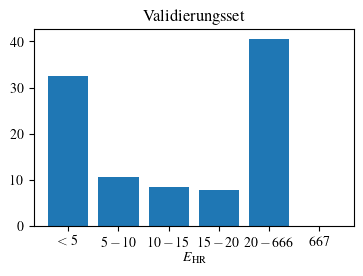

<Figure size 413.394x255.497 with 0 Axes>

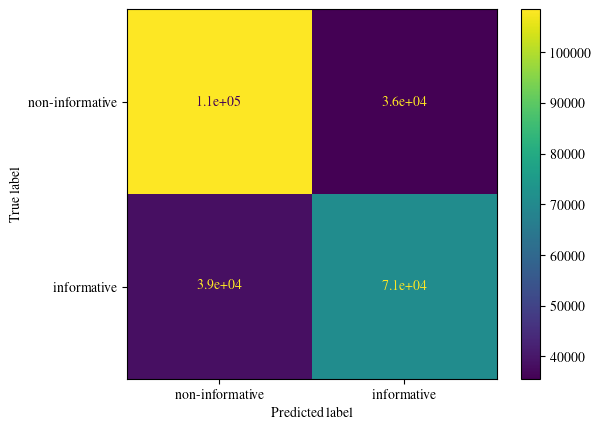

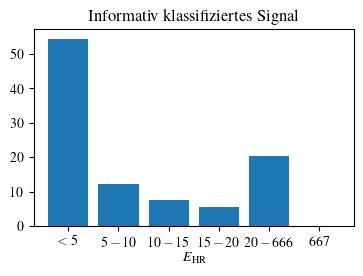

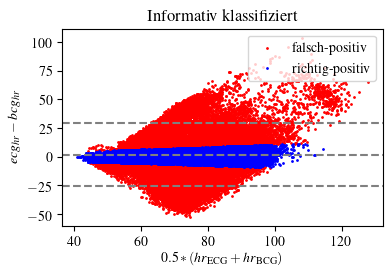

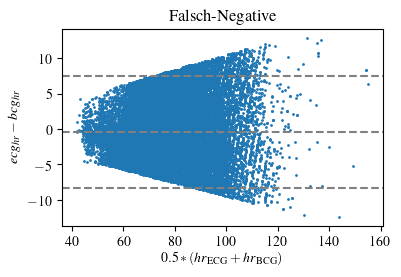

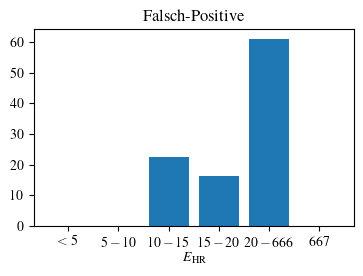

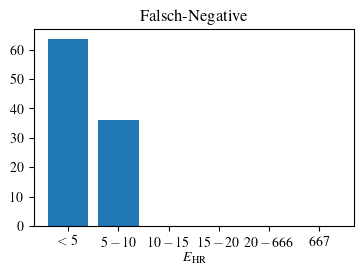

In [28]:
rf_clf_reduced.print_model_test_report()

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    3.3s finished


<Figure size 413.394x255.497 with 0 Axes>

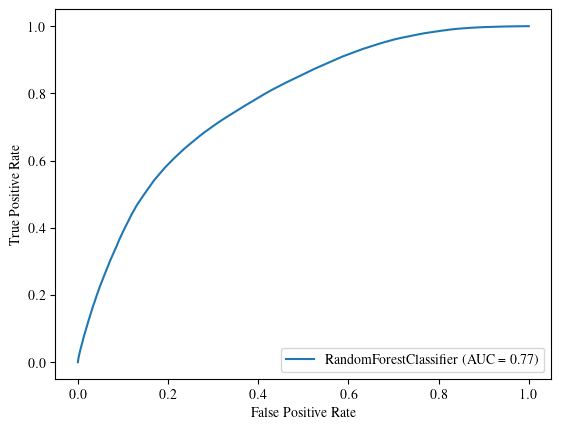

In [30]:
x1, x2, y1, y2, groups1, groups2 = rf_clf_reduced._get_patient_split()
plt.figure(figsize=utils.get_plt_normal_size())
x2 = x2.dropna()
y2 = y2.loc[x2.index]
plot_roc_curve(rf_clf_reduced.clf, x2, y2)

In [ ]:
# forest = RandomForestClassifier(random_state=1, n_jobs=-2)
forest = None

rf_clf = OwnEstimatorClassification(forest, path='rf_clf_2010.sav')

In [ ]:
rf_clf.print_model_test_report()

In [ ]:
forest_5 = RandomForestClassifier(random_state=1, n_jobs=-2)
#forest_5 = None

rf_clf_5 = OwnEstimatorClassification(forest_5, path='rf_clf_5_2010.sav')

In [ ]:
importances = rf_clf.clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(rf_clf.features.columns)):
    print("%2d) %-*s %f" % (f + 1, 30, rf_clf.features.columns[indices[f]], importances[indices[f]]))
plt.figure(figsize=utils.get_plt_big_size())
plt.bar(range(len(rf_clf.features.columns)), importances[indices], align='center')
plt.xticks(range(len(rf_clf.features.columns)), [name.replace("_", " ") for name in rf_clf.features.columns[indices]], rotation=45, ha="right")
plt.xlim([-1, len(rf_clf.features.columns)])
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

from ml_statistical_features import get_patient_split

In [ ]:
std_scaler = StandardScaler()

x1, x2, y1, y2, groups1, groups2 = get_patient_split(features, target, patient_id, test_size=0.33)

mask = x1.dropna().index
y1 = y1.loc[mask]
x_std = std_scaler.fit_transform(x1.dropna())

In [ ]:
pca = KernelPCA(n_components=2)
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
pca = KernelPCA(n_components=2, kernel='cosine')
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=1)
clf.fit(x_std, y1)
x_lda = clf.transform(x_std)
df_lda = pd.DataFrame(x_lda)
df_lda['informative'] = y1.values

sns.pairplot(df_lda, kind='scatter', hue='informative')

In [ ]:
from sklearn.linear_model import ElasticNet

x_train_std = std_scaler.transform(x_train.dropna(axis='index'))
mtl = ElasticNet()
mtl.fit(x_train_std, y_train_regr)

y_pred = mtl.predict(x_std)

y_pred_label = np.array([err < 10 for err in y_pred])
y_true_label = np.array([err < 10 for err in y_true])

ConfusionMatrixDisplay(confusion_matrix(y_true_label, y_pred_label), display_labels=class_names).plot()
print(classification_report(y_true_label, y_pred_label, target_names=class_names))

In [ ]:
pca = KernelPCA(n_components=2, kernel='rbf')
x_transform = pca.fit_transform(x_std)

df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

nca = NeighborhoodComponentsAnalysis(n_components=2)
x_nca = nca.fit_transform(x_std, y_test)

df_nca = pd.DataFrame(x_lda)
df_nca['informative'] = y_test.values

sns.pairplot(df_nca, kind='scatter', hue='informative')

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(x_train, y_train_regr)
# transform train input data
X_train_fs = fs.transform(x_train)

importances = fs.scores_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features.columns[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()